### Classification
Having seen some of the differences between the celllines, we might also be interested in understanding which features are actually predictive of the respective genotype/treatment. To that end, we will use classification analysis and take a look at the accuracies and the feature importance values:

In [25]:
addpath('../Classes','../Functions')
set(0, 'defaultFigureRenderer', 'painters')
warning('off','all')

In [26]:
load('../Data/full_dataset.mat')

In [27]:
batches = unique([nw_array.PlatingDate]); %Refer to different batches via their PlatingDate property
inclusion = {{'PlatingDate',batches([1:2])}}; %e.g. specify the batches to analyze by indexing the batches array // here we use the first two
exclusion = {{'DIV',16}}; %Example on how to exclude a certain recording day // here we don't exclude anything as DIV 16 does not exist
nw_filtered = filterObjectArray(nw_array,inclusion,exclusion); %Apply 

#### Set parameters

In [28]:
age_range = [0, 35]; %Set the week for which the features should be used // 6 uses all weeks
mat_idx = 1:2; %Indicate if single-cell, network, or both should be used // network is 1, single-cell is 2, both is 1:2
nw_sel = []; %Select specific network features // here we use all
sc_sel = []; %Select specific single-cell features // here we use all
alg = 'rf'; %Algorithm to be used // choices are 'svm','cnb','knn','rf'
kf = 5; %Number of kfold crossvalidations // default is 5
TH = 3; %Set outlier detection threshold, value refers to the median absolute deviation multiplier // default is 3
N_hyper = 0; %Number of iterations for hyperparameter optimization //0 skips hyperparameter optimization

In [29]:
[train_acc,feature_names,test_acc,mutation] = classify_genotypes(nw_filtered,age_range,mat_idx,nw_sel,sc_sel,alg,kf,TH,N_hyper);
fprintf('Average test accuracy was %.1f%%',mean(test_acc)*100)

Average test accuracy was 90.0%


In [40]:
acc_mat = nan(6,kf);
for w = 1:6
    if w <6
        age_range = [(w*7)-1,(w*7)];
    else
        age_range = [0, w*7];
    end
    [train_acc,feature_names,test_acc,mutation] = classify_genotypes(nw_filtered,age_range,mat_idx,nw_sel,sc_sel,alg,kf,TH,N_hyper);
    acc_mat(w,:) = test_acc;
end

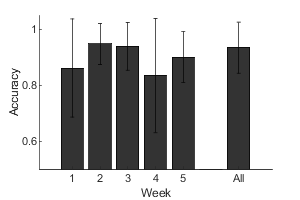

In [41]:
%plot --size 300,200
accuracy_barplot(acc_mat')

In [53]:
[train_err,sf_acc,feat_imp,input_features] = single_feature_classification(nw_filtered,age_range,mat_idx,kf,TH,N_hyper);

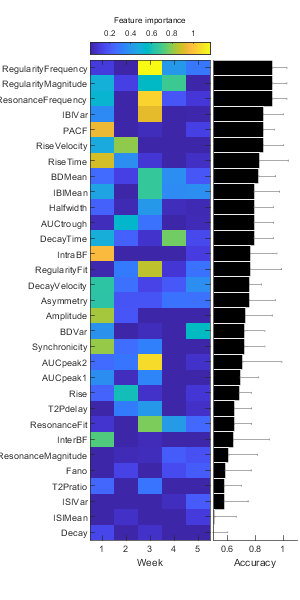

In [55]:
%plot --size 300,600
plot_feature_importance(sf_acc,feat_imp,input_features)

### Age regression
We might also be interested in understanding how good we can predict the age of different cultures e.g. to see if they show a normal development or when they reach a state of relative maturity.

Here, we create the input a bit differently, so you can specify distinct training and testing sets, e.g. you can train on control WT cultures and predict LNA-treated WT cultures. Therefore, we have inclusion arrays, where the first cell represents the training inclusion/exclusion parameters, while the second and/or third correspond to the testing set(s). Importantly, also the training set will be evaluated using leave-one-out CV. 

#### Set parameters

In [56]:
batches = unique([nw_array.PlatingDate]); %Refer to different batches via their PlatingDate property
inclusion_array = {{{'PlatingDate',batches([1:2])}}}; %e.g. specify the batches to analyze by indexing the batches array // here we use the first two
exclusion_array = {{}}; %Example on how to exclude a certain recording day // here we don't exclude anything as DIV 16 does not exist
vars2use = [1,2,4]; %Which variable sets to use // 1 is network, 2 is waveform, 4 is activity-based single-cell features
age_range = [0,40]; 

In [57]:
[age,pred_weeks,pI,vars,cl_train] = predictAgeFunction(nw_array,vars2use,age_range,inclusion_array,exclusion_array);

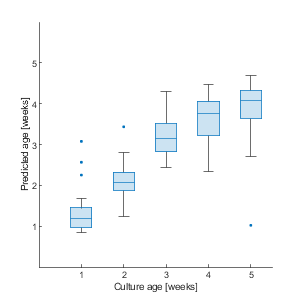

In [58]:
%plot --size 300,300
predictAgeBoxplot(age,pred_weeks);

We can now also evaluate if A53T cultures display a different developmental trajectory compared to WT cultures:

In [59]:
batches = unique([nw_array.PlatingDate]); %Refer to different batches via their PlatingDate property
inclusion_array = {{{'PlatingDate',batches([1:2])},{'Mutation','wt'}},... %We train on control WT cultures
                    {{'PlatingDate',batches([1:2])},{'Mutation','a53t'}}}; %And test how A53T cultures fare against them
exclusion_array = {{},...
                    {}}; 
vars2use = [1,2,4]; %We use all features to predict the age
age_range = [0,40]; 

In [60]:
[age,pred_weeks,pI,vars,cl_train] = predictAgeFunction(nw_array,vars2use,age_range,inclusion_array,exclusion_array);

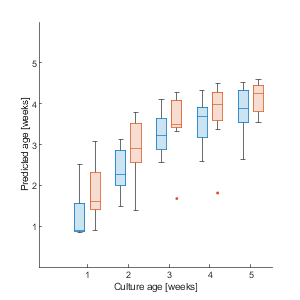

In [61]:
%plot --size 300,300
predictAgeBoxplot(age,pred_weeks);

Interesting! A53T cultures appear to be older than WT cultures, let's check which features were most important for the prediction:

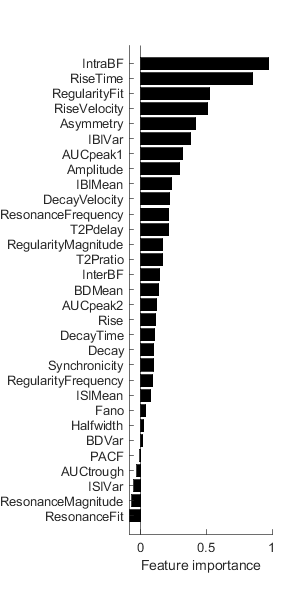

In [62]:
%plot --size 300,600
[sorted_pI,sort_idx] = sort(pI,'ascend');
barh(sorted_pI,'k');yticks(1:length(sorted_pI));yticklabels(vars(sort_idx));xlabel('Feature importance');box off;

So the top 3 features describe the bursting behavior of the cultures, which therefore seems to be the most predictive feature for the age of a culture. Let's take this one step further and see, what we can do if we apply a specific [treatment](treatment_evaluation.ipynb) to the cultures!